# Multi-task classification: Random forests and (Multitask)Lasso

In [1]:
import os
import urllib
import random
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..','download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

Wall time: 1min 50s


In [4]:
%%time
path = os.path.join('..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

Wall time: 1min 9s


In [5]:
#functions for data preprocessing and figure labels

def fs_mad(x, y):
    """
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))
# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=2000)

pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    )

def autolabel(rects,ay):
    # attach some text labels
    for rect in rects:
        width = rect.get_width()
        ay.text(1.05*width, rect.get_y() + rect.get_height()/2., 
                '%.2f' % width,
                ha='center', va='bottom')
        

In [6]:
# Mono-task classifiers, random forests and Lasso. Lasso results will be binarized. 

weights = {0:.4,1:.6}

Classifiers_mono = {
    "Random forest": RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=10, random_state=0,class_weight = weights),
    "Lasso": Lasso(alpha=0.1),
}


In [7]:
# Agents and targeted genes

# Afatinib (Gilotrif)

genes_Afatinib = {
    '1956':'EGFR',    
    '2064':'HER2',
    }

# Axitinib (Inlyta)

genes_Axitinib = {
    '3815':'KIT', 
    '5159':'PDGFRB',
    '2321':'FLT1', #VEGFR1
    '3791':'KDR', #VEGFR2    
    '2324':'FLT4', #VEGFR3
    }

# Cabozantinib (Cabometyx [tablet], Cometriq [capsule])

genes_Cabozantinib = {
    '2322':'FLT3',
    '3815':'KIT',
    '4233':'MET',
    '5979':'RET',
    '3791':'KDR', #VEGFR2 
    }

# Crizotinib (Xalkori)

genes_Crizotinib = {
    '238':'ALK',
    '4233':'MET',    
    '6098':'ROS1',
    }

# Imatinib (Gleevec)

genes_Imatinib = {
    '3815':'KIT',
    '5159':'PDGFRB',
    '25':'ABL',
    }

# Palbociclib (Ibrance)

genes_Palbociclib = {
    '1019':'CDK4',
    '1021':'CDK6',
    }

# Pazopanib (Votrient)

genes_Pazopanib = {
    '3791':'KDR',
    '5159':'PDGFRB',
    '3815':'KIT',
    }

# Ponatinib (Iclusig)

genes_Ponatinib = {
    '25':'ABL',
    '2263':'FGFR1-3',
    '2322':'FLT3',
    '3791':'KDR',
    }

# Regorafenib (Stivarga)

genes_Regorafenib = {
    '3815':'KIT',
    '5159':'PDGFRB',
    '5894':'RAF1',    
    '5979':'RET',
    '2321':'FLT1', #VEGFR1
    '3791':'KDR', #VEGFR2    
    '2324':'FLT4', #VEGFR3
    }

# Sorafenib (Nexavar)

genes_Sorafenib = {
    '3791':'KDR',
    '5159':'PDGFRB',    
    '3815':'KIT',
    '5894':'RAF1', 
    }

# Vandetanib (Caprelsa)

genes_Vandetanib = {
    '1956':'EGFR',
    '5979':'RET',
    '3791':'KDR',
    }

# Vismodegib (Erivedge)

genes_Vismodegib = {
    '5727':'PTCH1',
    '6608':'SMO',
    }

# Ziv-aflibercept (Zaltrap)

genes_Zaltrap = {
    '5281':'PIGF',
    '7422':'VEGFA',
    '7423':'VEGFB',
    }


In [8]:
# all targted genes, needed for comparison, store them in y

genes = {
    '1956':'EGFR',    
    '2064':'HER2',
    '3815':'KIT', 
    '5159':'PDGFRB',
    '2321':'FLT1', #VEGFR1
    '3791':'KDR', #VEGFR2    
    '2324':'FLT4', #VEGFR3
    '2322':'FLT3',
    '4233':'MET',
    '5979':'RET',
    '238':'ALK',    
    '6098':'ROS1',
    '25':'ABL',
    '1019':'CDK4',
    '1021':'CDK6',
    '2263':'FGFR1-3',
    '5894':'RAF1',    
    '5727':'PTCH1',
    '6608':'SMO',
    '5281':'PIGF',
    '7422':'VEGFA',
    '7423':'VEGFB',
    } 

y=Y[list(genes.keys())] 

In [9]:
# Using same training set for all targets
# Set aside 10% of the data for testing, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

features_train=pipeline.fit_transform(X=X_train, y=y_train) 
features_test=pipeline.fit_transform(X=X_test, y=y_test)

In [10]:
# Results for all genes when observed separately, accuracy score is used for evaluation

as_RF =[]
as_L = []
ps_RF =[]
ps_L = []

for GENE in list(genes.keys()):
    
    y_train_each = y_train[GENE]
    true_label = list(y_test[GENE])
    
    y_test_predict = dict()
    for name, classifier in Classifiers_mono.items():
        classifier.fit(features_train, y_train_each)
        y_test_predict[name] = classifier.predict(features_test)

    
    result_RF = y_test_predict['Random forest']
    result_L = binarize(y_test_predict['Lasso'].reshape(-1,1), threshold=0.5) 
    
    as_RF.append(accuracy_score(true_label,result_RF))
    as_L.append(accuracy_score(true_label,result_L))
    ps_RF.append(precision_score(true_label,result_RF))
    ps_L.append(precision_score(true_label,result_L))
    

C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predict

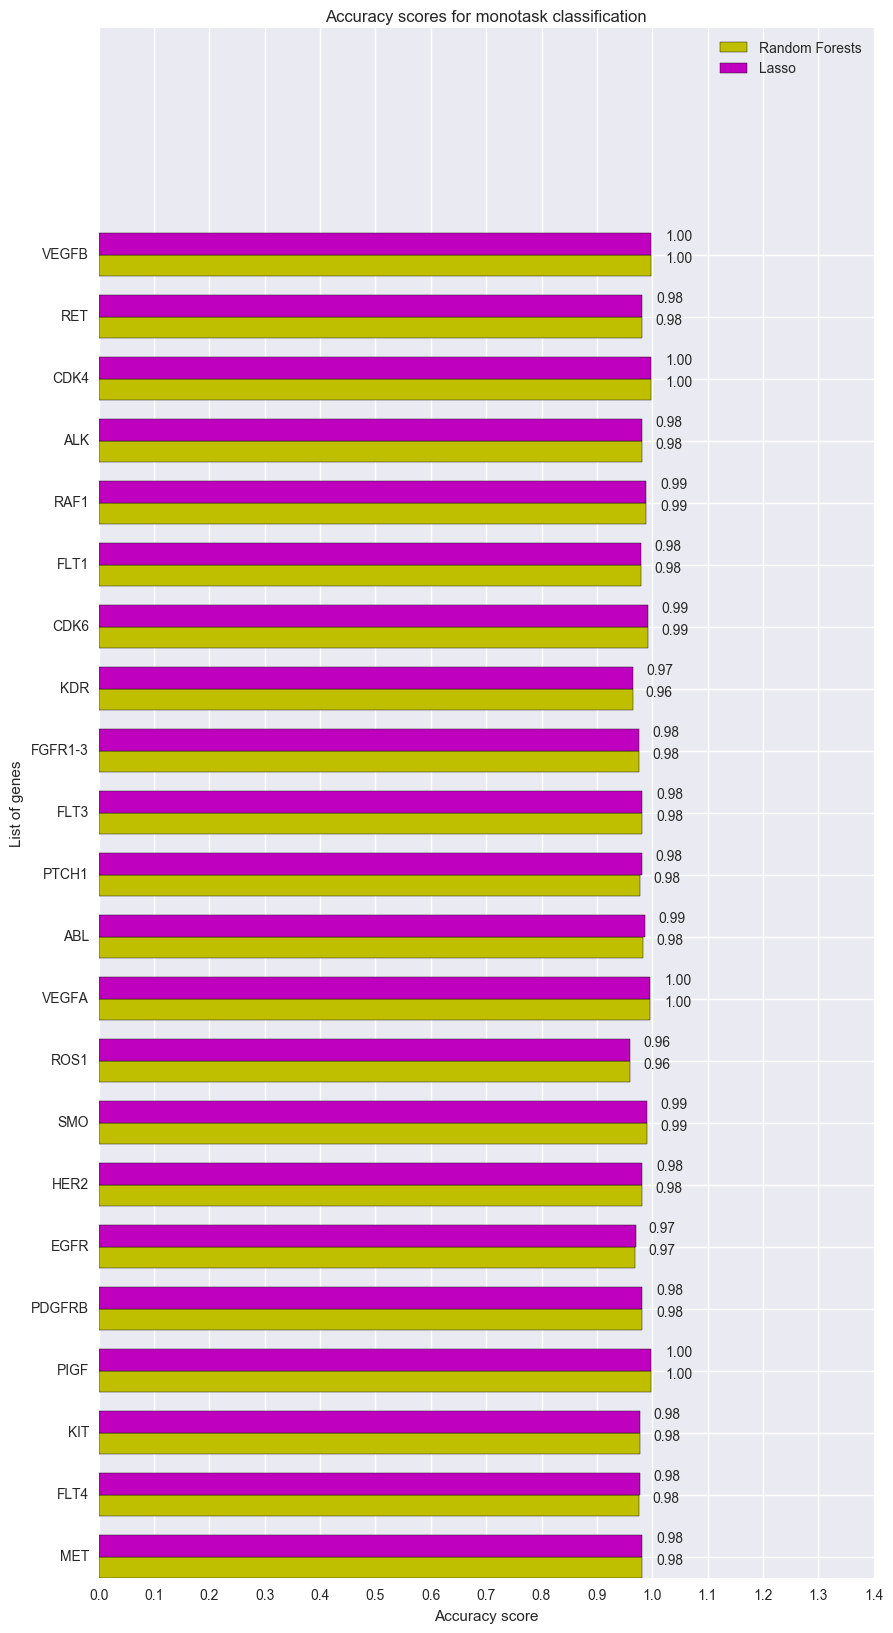

In [11]:
# plot for all genes  

width = 0.35       # the width of the bars

ind_genes = np.arange(len(as_RF))  # the y locations for the groups

fig_genes, as_genes = plt.subplots(figsize=(10, 20))

results_as_RF = as_genes.barh(ind_genes, as_RF, width, color='y')

results_as_L = as_genes.barh(ind_genes + width, as_L, width, color='m')

# add some text for labels, title and axes ticks
as_genes.set_xlabel('Accuracy score')
as_genes.set_title('Accuracy scores for monotask classification')
as_genes.set_ylabel('List of genes')
as_genes.set_yticks(ind_genes + width)
as_genes.set_yticklabels(genes.values())
as_genes.set_xticks(np.arange(0, 1.5, 0.1))

as_genes.legend((results_as_RF, results_as_L), ('Random Forests', 'Lasso'))

autolabel(results_as_RF,as_genes)
autolabel(results_as_L,as_genes)
 
plt.show()


In [12]:
# plot for all genes  - precision scores

#width = 0.35       # the width of the bars

#ind_genes = np.arange(len(ps_RF))  # the y locations for the groups

#fig_genes, ps_genes = plt.subplots(figsize=(10, 20))

#results_ps_RF = as_genes.barh(ind_genes, ps_RF, width, color='y')

#results_ps_L = as_genes.barh(ind_genes + width, ps_L, width, color='m')

# add some text for labels, title and axes ticks
#ps_genes.set_xlabel('Precision score')
#ps_genes.set_title('Precision scores for monotask classification')
#ps_genes.set_ylabel('List of genes')
#ps_genes.set_yticks(ind_genes + width)
#ps_genes.set_yticklabels(genes.values())
#ps_genes.set_xticks(np.arange(0, 1.5, 0.1))

#ps_genes.legend((results_ps_RF, results_ps_L), ('Random Forests', 'Lasso'))

#autolabel(results_ps_RF,ps_genes)
#autolabel(results_ps_L,ps_genes)
 
#plt.show()

Agents and corresponding targets 

In [13]:
# Insert the agent 

genes_Agent = genes_Ponatinib #Ponatinib Regorafenib

# Multi-task classifiers are defined here because class_weight depends on the number of columns, i.e., genes observed. 
# Following methods allow multi-task implementation: Extra trees, Knn, Random forests and MultiTask Lasso. Using Extra trees and
# KNN did not show any improvement and they are excluded from the analysis.

multi_weights = [weights for k in range(len (genes_Agent))]

Classifiers_multi = {
   # "Extra trees": ExtraTreesClassifier(),
   # "K-nn": KNeighborsClassifier(n_neighbors=20),
    "Random forest": RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=10, random_state=0,class_weight = multi_weights),
    "MultiTaskLasso": MultiTaskLasso(alpha=0.1),
}


In [14]:

y_train_Agent = y_train[list(genes_Agent.keys())] 
y_test_Agent = y_test[list(genes_Agent.keys())] 

y_test_predict_Agent = dict()
for name, classifier in Classifiers_multi.items():
    classifier.fit(features_train, y_train_Agent)
    y_test_predict_Agent[name] = classifier.predict(features_test)
    
res_RF_Agent = y_test_predict_Agent['Random forest']
res_MTL_Agent = y_test_predict_Agent['MultiTaskLasso'] 
        

In [15]:
# computing the scores

as_RF_Agent =[]
as_MTL_Agent = []
ps_RF_Agent =[]
ps_MTL_Agent = []

x = 0
for GENE in list(genes_Agent.keys()):
    result_RF_Agent = res_RF_Agent[:,x]
    result_MTL_Agent = binarize(res_MTL_Agent[:,x].reshape(-1,1), threshold=0.5)
    x = x + 1
    true_label_Agent = y_test_Agent[GENE]
    ps_RF_Agent.append(precision_score(true_label_Agent,result_RF_Agent))
    ps_MTL_Agent.append(precision_score(true_label_Agent,result_MTL_Agent))
    as_RF_Agent.append(accuracy_score(true_label_Agent,result_RF_Agent))
    as_MTL_Agent.append(accuracy_score(true_label_Agent,result_MTL_Agent))
    


C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


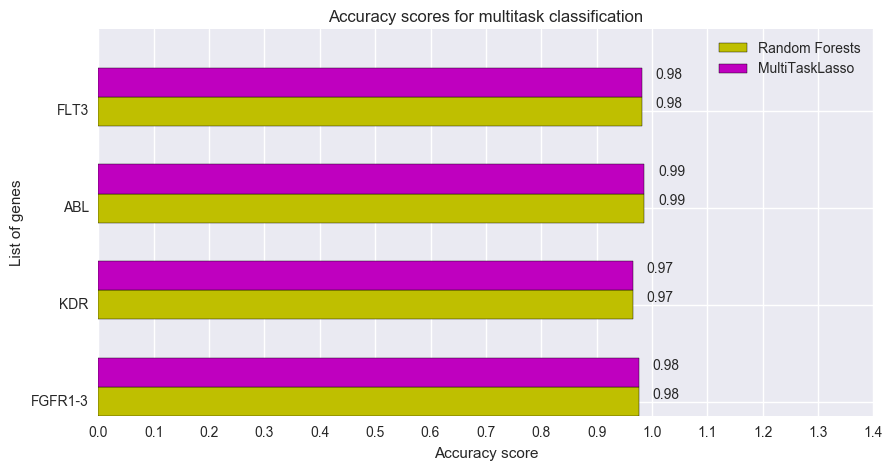

In [16]:
# plot for accuracy scores - Agent genes

width = 0.3       # the width of the bars

ind_genes_agent = np.arange(len(as_RF_Agent))  # the x locations for the groups

fig_genes_agent, as_genes_agent = plt.subplots(figsize=(10, 5))

ascores_RF_Agent = as_genes_agent.barh(ind_genes_agent, as_RF_Agent, width, color='y')

ascores_MTL_Agent = as_genes_agent.barh(ind_genes_agent + width, as_MTL_Agent, width, color='m')

# add some text for labels, title and axes ticks
as_genes_agent.set_xlabel('Accuracy score')
as_genes_agent.set_title('Accuracy scores for multitask classification')
as_genes_agent.set_ylabel('List of genes')
as_genes_agent.set_yticks(ind_genes_agent + .5*width)
as_genes_agent.set_yticklabels(genes_Agent.values())
as_genes_agent.set_xticks(np.arange(0, 1.5, 0.1))

as_genes_agent.legend((ascores_RF_Agent, ascores_MTL_Agent), ('Random Forests', 'MultiTaskLasso'))

autolabel(ascores_RF_Agent,as_genes_agent)
autolabel(ascores_MTL_Agent,as_genes_agent)


plt.show() 

In [17]:
# plot for precision scores - Agent genes

#width = 0.3       # the width of the bars

#ind_genes_agent = np.arange(len(as_RF_Agent))  # the x locations for the groups

#fig_genes_agent, ps_genes_agent = plt.subplots(figsize=(10, 10))

#pscores_RF_Agent = ps_genes_agent.barh(ind_genes_agent, ps_RF_Agent, width, color='y')

#pscores_MTL_Agent = ps_genes_agent.barh(ind_genes_agent + width, ps_MTL_Agent, width, color='m')

# add some text for labels, title and axes ticks
#ps_genes_agent.set_xlabel('Precision score')
#ps_genes_agent.set_title('Precision scores for multitask classification')
#ps_genes_agent.set_ylabel('List of genes')
#ps_genes_agent.set_yticks(ind_genes_agent + .5*width)
#ps_genes_agent.set_yticklabels(genes_Agent.values())
#ps_genes_agent.set_xticks(np.arange(0, 1.5, 0.1))

#ps_genes_agent.legend((pscores_RF_Agent, pscores_MTL_Agent), ('Random Forests', 'MultiTaskLasso'))

#autolabel(pscores_RF_Agent,ps_genes_agent)
#autolabel(pscores_MTL_Agent,ps_genes_agent)


#plt.show() 